In [4]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import pickle

# Calculating feature relationships

In [2]:
def con_cur_to_bgg_db():
    con = pg2.connect(host='34.216.22.202',
                  dbname='postgres',
                  user='postgres')
    cur = con.cursor(cursor_factory=RealDictCursor)
    return con, cur

In [26]:
def get_features():
    con, cur = con_cur_to_bgg_db()
    cur.execute('SELECT * FROM feature_lookup;')
    flist = cur.fetchall()
    con.close()
    return flist

In [30]:
def get_game_features():
    con, cur = con_cur_to_bgg_db()
    cur.execute('SELECT a.fid, a.gid, b.gs, b.gname FROM features a\
                 INNER JOIN boardgames b ON a.gid=b.gid;')
    gflist = cur.fetchall()
    con.close()
    return gflist

## Get full feature list

In [27]:
flist = get_features()
f_df = pd.DataFrame(flist)

In [42]:
f_df.set_index('fid', inplace=True)

## Get game list with features and gs

In [31]:
gflist = get_game_features()
gf_df = pd.DataFrame(gflist)
len(gflist)

79788

In [32]:
gf_names = pd.merge(gf_df, f_df, left_on='fid', right_on='fid', how='left')

In [33]:
gf_names.head()

,fid,gid,gname,gs,fclass,fname
0,5499,13,Catan,1,sub,Family Games
1,5497,13,Catan,1,sub,Strategy Games
2,3,13,Catan,1,fam,Catan
3,11505,13,Catan,1,fam,Promotional Board Games
4,2072,13,Catan,1,mec,Dice Rolling


In [69]:
gf_names.set_index('gs', inplace=True)

## Select features with more than 10 games

In [71]:
feat_mask = gf_names.fid.value_counts() > 10
sum(feat_mask)

453

## Filter features to only those with > 10 games

In [72]:
feat_df = f_df[feat_mask]
len(feat_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


453

## Trim game df to remove these filtered features

In [73]:
feat_list = list(feat_df.index)
trim_mask = gf_names.fid.isin(feat_list)
trimmed_gf = gf_names[trim_mask]
trimmed_gf['fid'] = trimmed_gf.fid.map(lambda x: str(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Get dummy variables for SVD, convert to vector of game features

In [82]:
gf_dummies = pd.get_dummies(trimmed_gf[['fid']])
sparse_gf = gf_dummies.groupby(gf_dummies.index).sum()
sparse_gf.head()

,fid_100,fid_1001,fid_1002,fid_1008,fid_1009,fid_101,fid_1010,fid_1011,fid_1013,fid_10137,...,fid_9043,fid_9470,fid_9644,fid_9733,fid_9768,fid_9793,fid_98,fid_99,fid_9961,fid_9974
gs,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
sparse_gf.to_pickle('../data/sparse_gf_full')

# Compute SVD

In [90]:
from sklearn.decomposition import TruncatedSVD

In [131]:
SVD = TruncatedSVD(n_components=80)
svd_matrix = SVD.fit_transform(sparse_gf)
svd_matrix.shape

(10000, 80)

In [132]:
with open('../data/svd_matrix_full', 'wb') as f:
    pickle.dump(svd_matrix, f)

In [133]:
SVD.components_.shape

(80, 453)

In [134]:
with open('../data/svd_components_full', 'wb') as f:
    pickle.dump(SVD.components_, f)

## Plot explained variance

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

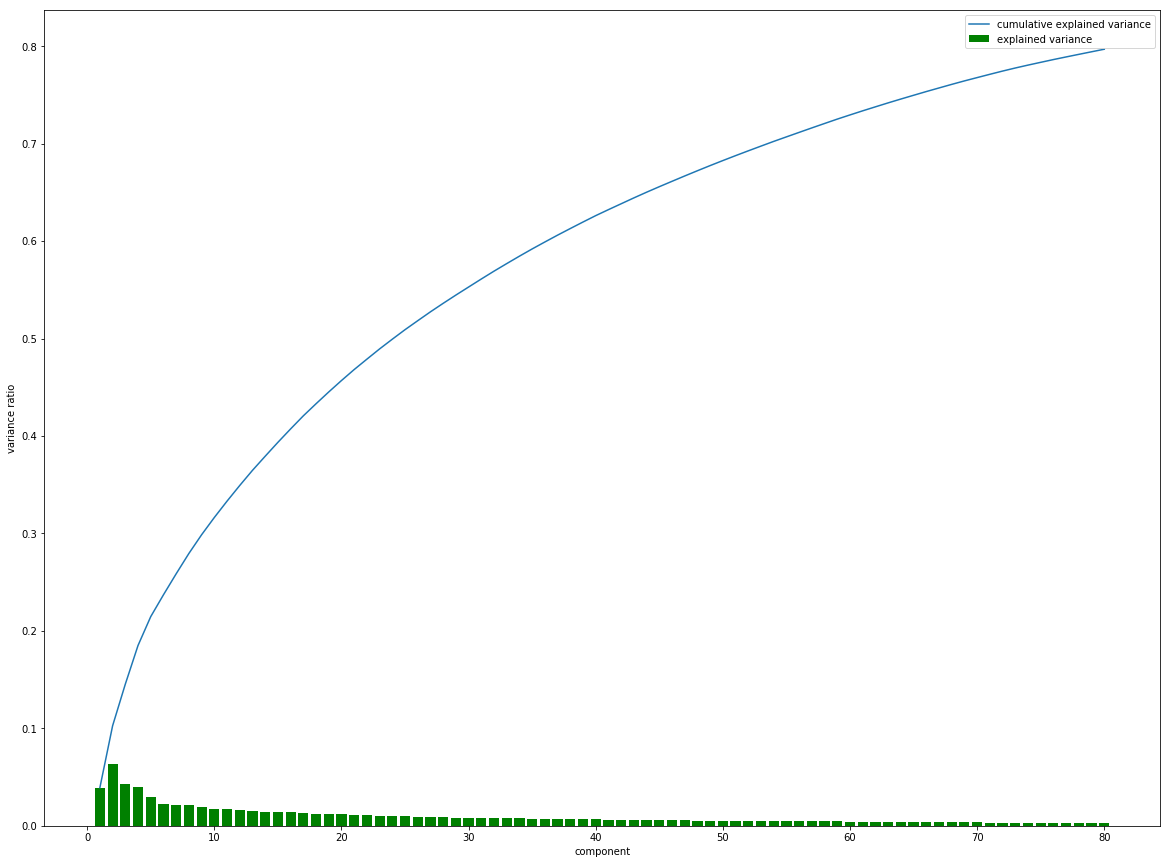

In [136]:
fig = plt.figure(figsize=(20,15))
plt.bar(np.array(range(80))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(80))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend()
plt.xlabel('component')
plt.ylabel('variance ratio')

## Convert matrix to df for easy interpretation

In [138]:
component_names = ["component_"+str(i+1) for i in range(80)]
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)
svd_df.insert(0, 'gs', sparse_gf.index)
svd_df.set_index('gs', inplace=True)

In [139]:
svd_df.to_pickle('../data/svd_df_full')

## Map feature names back on fid for easy interpretation

In [140]:
fid_mapper = pd.DataFrame(flist)
fid_mapper['fid'] = fid_mapper.fid.map(lambda x : 'fid_{}'.format(x))
fid_map_mask = fid_mapper.fid.isin(sparse_gf.columns)
fid_map = fid_mapper[fid_map_mask]
fid_map.set_index('fid', inplace=True)
fid_map.sort_index(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Make feature loadings matrix

In [141]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=fid_map.fname).T

In [142]:
loadings.to_pickle('../data/loadings_df_full')

In [143]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)

In [144]:
loadings['abs_component_80'] = np.abs(loadings.component_80)

In [147]:
loadings.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]

,component_1
fname,
Dice Rolling,0.357219
Hand Management,0.345651
Card Game,0.335190
Variable Player Powers,0.304298
Expansion for Base-game,0.260287
Fantasy,0.245236
Strategy Games,0.201691
Fighting,0.195867
Thematic Games,0.154776


## Get gnames for search results

In [3]:
def get_gnames():
    con, cur = con_cur_to_bgg_db()
    cur.execute('SELECT gid, gs, gname FROM boardgames;')
    gnames = cur.fetchall()
    con.close()
    return gnames

In [4]:
gnames = get_gnames()

In [101]:
gname_df = pd.DataFrame(gnames)
gname_df.set_index('gs', inplace=True)
gname_df.sort_index(inplace=True)
gname_df.head(15)

,gid,gname
gs,,
1,13,Catan
2,822,Carcassonne
3,30549,Pandemic
4,36218,Dominion
5,68448,7 Wonders
6,9209,Ticket to Ride
7,31260,Agricola
8,3076,Puerto Rico
9,40692,Small World


In [5]:
gname = {}
for row in gnames:
    gname[row['gs']-1] = row['gname']

gs = {}
for row in gnames:
    gs[row['gname']] = row['gs']-1

gid = {}
for row in gnames:
    gid[row['gs']-1] = row['gid']

In [11]:
with open('../data/gname', 'wb') as f:
    pickle.dump(gname, f)
    
with open('../data/gs', 'wb') as f:
    pickle.dump(gs, f)
    
with open('../data/gid', 'wb') as f:
    pickle.dump(gid, f)

## Precompute full cosine similarity matrix for fast access

In [154]:
cos_sim_mat = cosine_similarity(svd_matrix, svd_matrix)
cos_sim_mat.shape

(10000, 10000)

In [155]:
with open('../data/cos_sim_mat_full', 'wb') as f:
    pickle.dump(cos_sim_mat, f)